In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [19]:
df = pd.read_excel('2020_clean.xlsx', parse_date=True)
df = df.set_index('Date')
df.index = df.asfreq('D').index

In [20]:
df = df['Q'].resample('MS').sum()

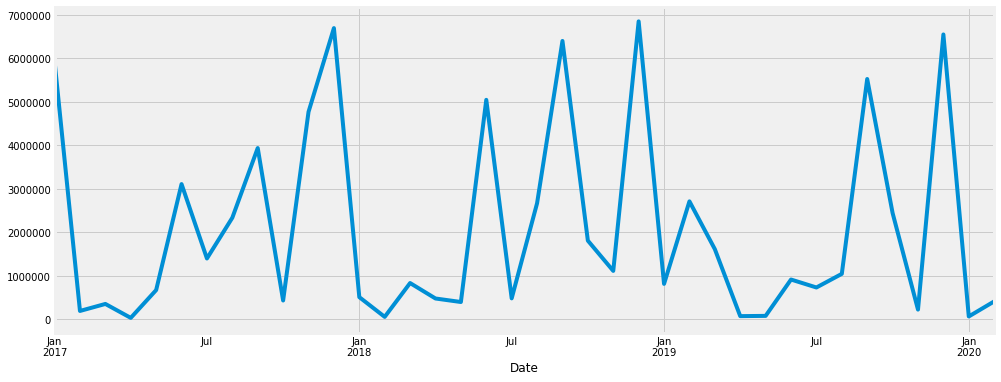

In [21]:
df.plot(figsize=(15,6))

In [22]:
# Определите p, d и q в диапазоне 0-2
p = d = q = range(0, 2)
# Сгенерируйте различные комбинации p, q и q
pdq = list(itertools.product(p, d, q))
# Сгенерируйте комбинации сезонных параметров p, q и q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [23]:
warnings.filterwarnings("ignore") # отключает предупреждения
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1209.347951581683
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:101331066.46467705
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:786.5419117932933
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:822.9417145092825
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:796.4499910907784
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:442.2083538462119
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1174.470679725879
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:101301531.52831541
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:758.1852193758568
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:836.8143097873503
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:774.4910509900021
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:444.4700147191843
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1182.1465305435433
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:nan
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:772.0319985362182
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:806.2300070257288
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:nan
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:418.9538839974053
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AI

In [24]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

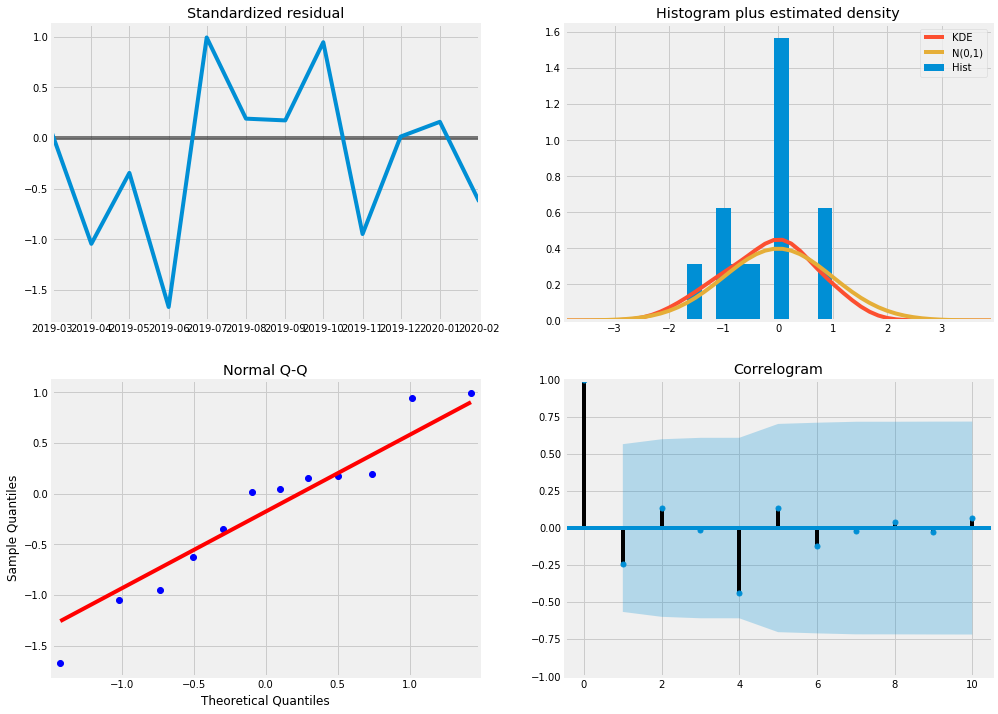

In [25]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [26]:
pred = results.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred.conf_int()

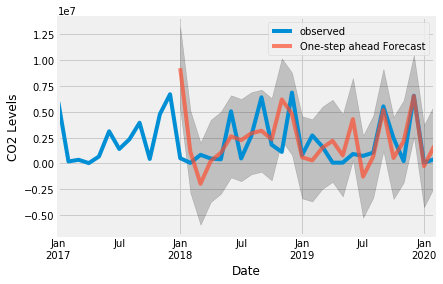

In [27]:
ax = df['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.show()

In [28]:
y_forecasted = pred.predicted_mean
y_truth = df['2018-01-01':]
# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 6561986387743.65


In [29]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

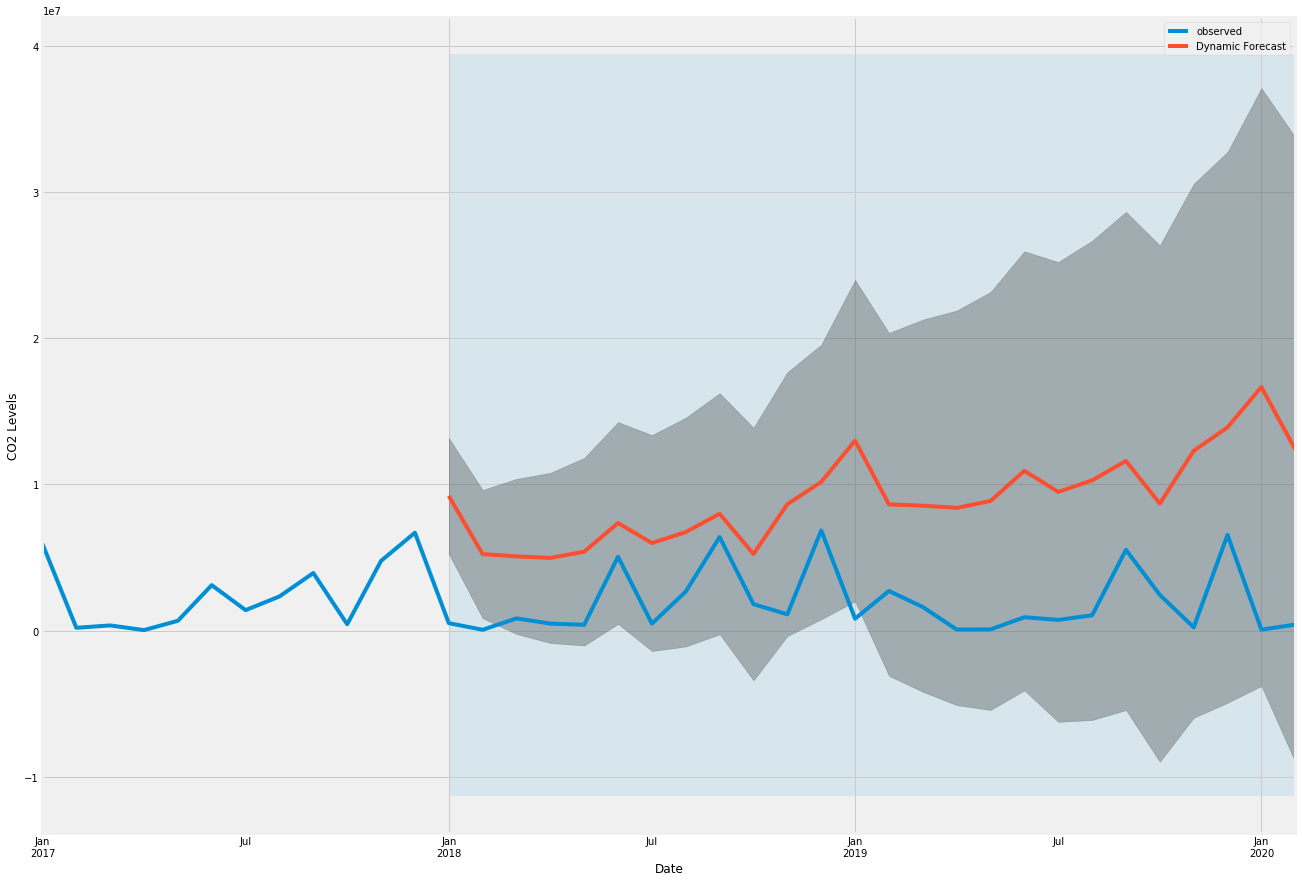

In [30]:
ax = df['2016':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)
ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], 
                color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2018-01-01'), df.index[-1],
                 alpha=.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.show()

In [31]:
y_forecasted = pred_dynamic.predicted_mean
y_truth = df['2018-01-01':]
# Вычислить среднеквадратичную ошибку
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#The Mean Squared Error of our forecasts is 1.01

The Mean Squared Error of our forecasts is 62865137261344.78


In [32]:
# Получить прогноз на 500 шагов вперёд
pred_uc = results.get_forecast(steps=12)
# Получить интервал прогноза
pred_ci = pred_uc.conf_int()

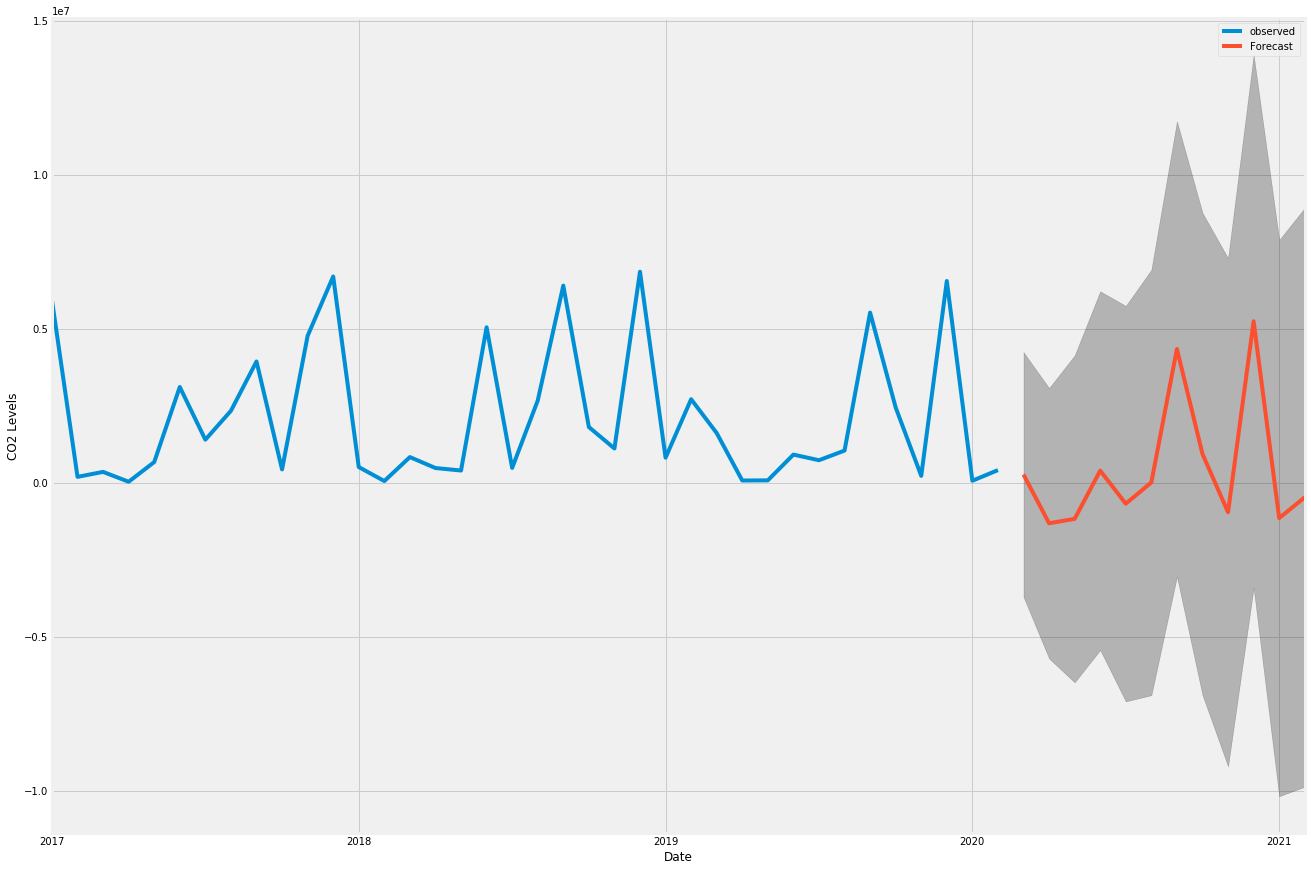

In [33]:
ax = df.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.show()

In [34]:
res = pred_ci.copy()

In [35]:
res['res'] = res['lower Q'] + res['upper Q']

In [36]:
res['year'] = ''
res['date'] = pd.to_datetime(res.index)

for i in range(len(res['date'])):
    res['year'][i] = res['date'][i].timetuple().tm_year

In [37]:
res['castil'] = res['res'] - float(res.res.min())

In [38]:
res

,lower Q,upper Q,res,year,date,castil
2020-03-01,-3.699647e+06,4.240251e+06,5.406044e+05,2020,2020-03-01,3.163339e+06
2020-04-01,-5.700589e+06,3.077855e+06,-2.622735e+06,2020,2020-04-01,0.000000e+00
2020-05-01,-6.474500e+06,4.136752e+06,-2.337747e+06,2020,2020-05-01,2.849877e+05
2020-06-01,-5.425263e+06,6.216913e+06,7.916499e+05,2020,2020-06-01,3.414385e+06
2020-07-01,-7.094428e+06,5.742859e+06,-1.351569e+06,2020,2020-07-01,1.271166e+06
2020-08-01,-6.890198e+06,6.916306e+06,2.610837e+04,2020,2020-08-01,2.648843e+06
2020-09-01,-3.040614e+06,1.173200e+07,8.691386e+06,2020,2020-09-01,1.131412e+07
2020-10-01,-6.886959e+06,8.761968e+06,1.875009e+06,2020,2020-10-01,4.497744e+06
2020-11-01,-9.202223e+06,7.291672e+06,-1.910552e+06,2020,2020-11-01,7.121832e+05
2020-12-01,-3.401764e+06,1.388820e+07,1.048644e+07,2020,2020-12-01,1.310917e+07


In [39]:
res.groupby('year').sum()[['res']]

,res
year,
2020,1.418859e+07
2021,-3.225576e+06


In [40]:
res.groupby('year').sum()[['castil']]

,castil
year,
2020,4.041594e+07
2021,2.019894e+06
